# Experiment Objective
The objective of this experiment is to understand the impact of segment length on wave propagation, as simulated with the Muskingum-Cunge routing model. **How does segment length affect the timing and shape of a simulated waves along a 10-km reach?** This (simple) experiment is needed to help focus objectives and set expectations for changing segment lengths on the NHDPlus network. Namely, if we decrease the ubiquity of small segments by merging them with adjacent ones, how do we expect wave shapes to change?  

# Experiment details
- 10-km reach with uniform geometric and roughness parameters. 
- A Gaussian-shaped pulse at the upper boundary
- Sample the simulated output at the bottom of the reach
- 60 second time step
- Repeat simulations for a series of segment lengths, ranging from 50 to 5000 meters. *Note*: The reach length remains the same across simulations, only segment lengths change. So the reach is composed of more segments when dx is small, and fewer segments with dx is large. 

# Environment set up
The cell below imports necessary modules and t-route functions. Additionally, logic is included to enable the notebook to be run on Google Colab.   

In [1]:
import os
import sys
import subprocess
import glob
import pathlib

# logic to accomodate Google Colab
try:
    import google.colab

    ENV_IS_CL = True

    root = pathlib.Path("/content/t-route").resolve()
    subprocess.run(
        [
            "git",
            "clone",
            "-b",
            "segment-merge",
            "https://github.com/awlostowski-noaa/t-route.git",
        ]
    )
    
    
    ! pip install geopandas

except:
    ENV_IS_CL = False
    root = pathlib.Path("..").resolve()

# modify path
fortran_source_dir = os.path.join(
    root, "src", "fortran_routing", "mc_pylink_v00", "MC_singleSeg_singleTS"
)
sys.path.append(fortran_source_dir)
routing_v02_dir = os.path.join(root, "src", "python_routing_v02")
sys.path.append(routing_v02_dir)    
sys.path.append(os.path.join(root, "src", "python_framework_v02"))
sys.path.append(os.path.join(root, "src", "python_framework_v01"))

fortran_source_dir = os.path.join(
    root, "src", "fortran_routing", "mc_pylink_v00", "MC_singleSeg_singleTS"
)
sys.path.append(fortran_source_dir)
routing_v02_dir = os.path.join(root, "src", "python_routing_v02")
sys.path.append(routing_v02_dir)
sys.path.append(os.path.join(root, "src", "python_framework_v02"))
sys.path.append(os.path.join(root, "src", "python_framework_v01"))

# compile cython routing script
COMPILE_cython = True
# ! This will definitely work in the Google Colab environment, though may not work
# in your local envioronment.
if COMPILE_cython:

    subprocess.run(
        ["gfortran", "varPrecision.f90", "-c", "-o", "var_precision.o", "-O3", "-fPIC"],
        cwd=fortran_source_dir,
    )
    subprocess.run(
        [
            "gfortran",
            "MCsingleSegStime_f2py_NOLOOP.f90",
            "-c",
            "-o",
            "mc_single_seg.o",
            "-O3",
            "-fPIC",
        ],
        cwd=fortran_source_dir,
    )
    subprocess.run(
        [
            "gfortran",
            "pyMCsingleSegStime_NoLoop.f90",
            "-c",
            "-o",
            "pymc_single_seg.o",
            "-O3",
            "-fPIC",
        ],
        cwd=fortran_source_dir,
    )

    for obj_file in glob.glob(os.path.join(fortran_source_dir, "*.o")):
        print(obj_file)
        subprocess.run(["cp", obj_file, routing_v02_dir])

    if ENV_IS_CL:
        numpy_I = "/usr/local/lib/python3.6/dist-packages/numpy/core/include"
        py_I = "/usr/include/python3.6"
        py_lib = "/usr/include/python3.6"

    else:
        bin_exe = pathlib.Path(sys.executable)
        virtual_env_path = bin_exe.parents[1]
        py_lib = os.path.join(virtual_env_path, "lib")
        numpy_I = os.path.join(
            py_lib, "python3.6", "dist-packages", "numpy", "core", "include"
        )
        py_I = os.path.join(virtual_env_path, "include", "python3.6m")

    subprocess.run(
        [
            "cython",
            "-3",
            "-v",
            "-p",
            "--line-directives",
            "-Wextra",
            "--cleanup",
            "3",
            "mc_reach.pyx",
        ],
        cwd=routing_v02_dir,
    )
    subprocess.run(
        [
            "gcc",
            "-pthread",
            "-Wno-unused-result",
            "-Wsign-compare",
            "-DNDEBUG",
            "-g",
            "-fwrapv",
            "-O3",
            "-fno-strict-aliasing",
            "-Wall",
            "-Wstrict-prototypes",
            "-fPIC",
            "-I",
            numpy_I,
            "-I",
            py_I,
            "-c",
            "mc_reach.c",
            "-o",
            "mc_reach.o",
        ],
        cwd=routing_v02_dir,
    )
    subprocess.run(
        [
            "gcc",
            "-pthread",
            "-shared",
            "-L",
            py_lib,
            "var_precision.o",
            "mc_single_seg.o",
            "pymc_single_seg.o",
            "mc_reach.o",
            "-lgfortran",
            "-o",
            "mc_reach.cpython-36m-x86_64-linux-gnu.so",
        ],
        cwd=routing_v02_dir,
    )

# load needed scientific libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from itertools import chain
from functools import partial

# turn off warnings
import warnings
warnings.simplefilter("ignore")

# import t-route functions for network analysis
import nhd_io
import nhd_network
import mc_reach


/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/mc_single_seg.o
/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/pymc_single_seg.o
/mnt/c/Users/awlostowski/Documents/national-water-center/t-route/src/fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS/var_precision.o


# Simulation function
The cell below is a function to execute the experiment simulations. When the function is called, the segment length is passed as `dx`. The segment length needs to be a factor of 10000 meters.

In [2]:
def sim(dx):

    ################################################
    # Set-up model domain
    ################################################
    # SPACE
    L = 10 * (1000) # meters
    nsegs = round(L/dx)

    # TIME
    n_days = 6
    len_sim = n_days*(24*60*60) # seconds
    dt = 60
    nts = round(len_sim/dt)

    ################################################
    # Create model parameter set
    ################################################
    link_start = 8815967 # arbitrary linkID for the top segment of the reach
    headwaters = [8815960, 8815961] # create two headwaters, one of which will accept lateral inflows

    # construct linkIDs and destination linkIDs
    linkID = list(range(link_start,
                        link_start + nsegs,
                        1))
    linkID = headwaters + linkID

    headwater_to = [link_start, link_start]
    toID = list(range(link_start + 1,
                      link_start + nsegs,
                      1))
    toID.append(0)
    toID = headwater_to + toID

    # link-distance lookup - what is the physical distance associated with each segment? 
    link_distance = {}
    for i, link in enumerate(linkID[2:],1):
        link_distance[i*dx] = link

    # build parameter DataFrame
    d = {'link': linkID,
          'to': toID,
          'dx': [dx] * (nsegs+2),
          'n': [0.028] * (nsegs+2),
          'ncc': [0.031] * (nsegs+2),
          's0': [0.0018] * (nsegs+2),
          'bw': [112] * (nsegs+2),
          'tw': [448] * (nsegs+2),
          'twcc': [623] * (nsegs+2),
          'MusK': [3600.0] * (nsegs+2),
          'MusX': [0.2] * (nsegs+2),
          'cs': [1.40] * (nsegs+2)}

    df = pd.DataFrame(data=d)
    df = df.set_index('link')
    df = df.sort_index()

    # replace downstreams for terminal segments
    df = nhd_io.replace_downstreams(df, 'to', 0)

    ################################################
    # Create lateral inflow data
    ################################################
    t_pk = 2*24*(60*60)
    width = 2*(60*60)
    q_pk = 0.5 #cms
    q_baseflow = 1

    x = np.linspace(0,len_sim, round(len_sim/dt))
    y = norm.pdf(x,t_pk,width)
    y_scale = y * q_pk/max(y) + q_baseflow

    # construct lateral inflow series
    ql = pd.DataFrame(0, index=linkID, columns=range(round(len_sim/dt)),dtype=np.float64)
    ql.iloc[0,:] = y_scale

    ################################################
    # Build network
    ################################################
    conn = nhd_network.extract_connections(df, 'to')
    rconn = nhd_network.reverse_network(conn)
    subnets = nhd_network.reachable_network(rconn, check_disjoint = False)

    # identify the segments in each subnetwork
    subreachable = nhd_network.reachable(rconn)

    # break each subnetwork into reaches
    subreaches = {}
    for tw, net in subnets.items():
        path_func = partial(nhd_network.split_at_junction, net)
        subreaches[tw] = nhd_network.dfs_decomposition(net, path_func)

    tail_water = max(linkID)
    reach = subreaches[tail_water]
    r = list(filter(None, chain.from_iterable(reach)))

    ################################################
    # Simulate network routing
    ################################################
    # add a dt column to the data DataFrame
    df["dt"] = dt

    # change variables to type float32, as expected by mc_reach.compute_network
    df = df.astype("float32")

    # prep parameter and lateral inflow data to be fed to routing model
    data_sub = df.loc[
        r, ["dt", "dx", "bw", "tw", "twcc", "n", "ncc", "cs", "s0"]
    ].sort_index()

    # create qlat dataset
    qlat_sub = ql.loc[r].sort_index()

    # compute the network routing, calculate (flow, depth, and velocity)
    results = []

    results.append(
        mc_reach.compute_network(
            nts,
            reach,
            subnets[tail_water],
            data_sub.index.values.astype("int64"),
            data_sub.columns.values,
            data_sub.values,
            qlat_sub.values.astype("float32"),
            assume_short_ts=False
        )
    )

    ################################################
    # re-format simulation output
    ################################################

    # create a multi-index DataFrame with flow, depth, and velocity simulations
    fdv_columns = pd.MultiIndex.from_product([range(nts), ["q", "v", "d"]])
    flowveldepth = pd.concat(
        [pd.DataFrame(d, index=i, columns=fdv_columns) for i, d in results], copy=False
    )
    flowveldepth = flowveldepth.sort_index()

    # identify segment ID at 10 km
    x_sample = link_distance[10000]

    flows = flowveldepth.loc[x_sample, (slice(None), "q")]
    flows = flows.T.reset_index(level = [0,1])
    flows.rename(columns = {"level_0": "Timestep", "level_1": "Parameter"}, inplace = True)
    flows.rename(columns = {x_sample: "10-km"}, inplace = True)

    flows['Forcing'] = ql.loc[linkID[0],:].T
    flows['Time (d)'] = ((flows.Timestep + 1) * dt)/(24*60*60)
    flows = flows.set_index('Time (d)')
    
    flows = flows.drop(["Timestep", "Parameter"], axis=1)
    
    return flows, x_sample

# Segment length sensitivity analysis
The cell below calls the simulation function above several times, each with a different segment length variable, `dx`. Simulation results are concatenated into a single DataFrame, where different columns contain simulated flows at 10-km for various values of `dx`.

In [3]:
dx = [50,100,200,500,1000,2000,5000]

# run the model for each dx, save output in a DataFrame
for i, d in enumerate(dx,1):
    
    if i == 1:
        flows, x_sample = sim(d)
        flows.rename(columns = {"10-km": d}, inplace = True)
        flows = flows.loc[:,["Forcing",d]]
        
    else:
        flows_n, x_sample = sim(d)
        flows_n.rename(columns = {"10-km": d}, inplace = True)
        
        flows[d] = flows_n[d]
    


## Visualize experiment results
The cell below plots the forcing signal, along with simulated flows at 10-km for various segment lengths. 

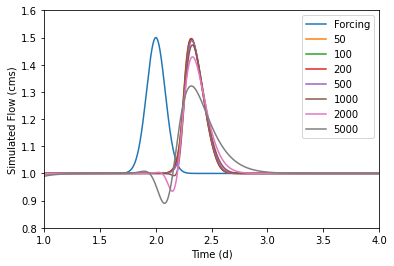

In [4]:
ax = flows.loc[:,:].plot()
plt.xlim([1,4])
plt.ylim([0.8,1.6])
plt.ylabel("Flow (cms)")

plt.show()


## Assess simulation mass balance
The cell below calculates the amount of mass recovered at 10-km, relative the amount of mass injected as lateral inflows. A graph is produced to illustrate the sensitivity of mass balance to segment length. 

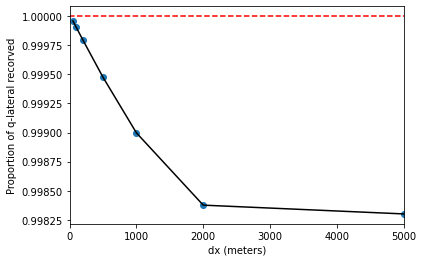

In [5]:
# look at mass balance

y = []
for i, d in enumerate(flows.columns):

    if i == 0:
        Forcing = flows[flows.index > 1.5].loc[:,d].sum() * 60
    else:
        y.append((flows[flows.index > 1.5].loc[:,d].sum() * 60)/Forcing)
    


plt.scatter(dx, y)
plt.plot(dx, y,'k-')
plt.ylabel("Proportion of q-lateral recorved")
plt.xlabel("dx (meters)")
plt.hlines(1,-10,5010,color = 'r', linestyles = 'dashed')
plt.xlim([0,5010])

plt.show()
    


# Experiment Results
1. Coarsening the reach with larger segments 
    - **delays the flood wave arrival**
    - **lowers the flood peak**
    - **extends flood recession**
    - **disturbs mass balance**

2. When the reach is too coarse (equal to or greater than 100 meters in this case), a strange thing happens whereby simulated flows decrease prior to the wave arrival. This looks like an instability, but CFL << 1